# British Columbia, Canada - Lidar point cloud

This is a point cloud sliced to the small
[Trail Islands](https://apps.gov.bc.ca/pub/bcgnws/names/21973.html) to the
North of Vancouver to reduce the data size.
The islands have some nice looking topography and their isolated nature creates
problems for some interpolation methods, like simple nearest-neighbors.

**Source:** [LidarBC](https://www2.gov.bc.ca/gov/content/data/geographic-data-services/lidarbc)

**License:** [Open Government Licence - British Columbia](https://www2.gov.bc.ca/gov/content/data/open-data/open-government-licence-bc)

## Notes

Coordinates of the original data are in NAD83 UTM zone 10 and the vertical datum for elevation is CGVD2013 (based on the Canadian geoid). We will change the horizontal datum to WGS84  with geodetic latitude and longitude to standardize with out other data.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt
import laspy 

## Download the data

Use [Pooch](https://github.com/fatiando/pooch) to download the original data file to our computer.

In [2]:
fname = pooch.retrieve(
    url="https://nrs.objectstore.gov.bc.ca/gdwuts/092/092g/2019/pointcloud/bc_092g041_4_2_2_xyes_8_utm10_2019.laz",
    known_hash="md5:5acad29ff5ba1f2a09453ed16c3004da",
)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 83.871764 Mb


## Read the data

Use laspy to read in the data from the file. We'll read it in chunks and only take the ground reflection points to avoid overloading our memory.

In [3]:
easts, norths, heights = [], [], []
with laspy.open(fname) as lasfile:
    for chunk in lasfile.chunk_iterator(100_000):
        ground = chunk.classification == 2
        easts.append(chunk.x.scaled_array()[ground].copy())
        norths.append(chunk.y.scaled_array()[ground].copy())
        heights.append(chunk.z.scaled_array()[ground].copy())
        
data_full = pd.DataFrame({
    "easting": np.concatenate(easts),
    "northing": np.concatenate(norths),
    "elevation_m": np.concatenate(heights),
})
data_full

,easting,northing,elevation_m
0,441500.56,5479185.08,-1.14
1,441500.54,5479184.50,-1.15
2,441500.43,5479183.88,-1.10
3,441500.84,5479184.13,-1.14
4,441501.26,5479184.38,-1.13
...,...,...,...
2489382,442012.88,5477949.65,-0.37
2489383,442012.58,5477949.15,-0.47
2489384,442014.16,5477950.85,-0.06
2489385,442013.24,5477949.33,-0.40


## Cut the data

Slice the data to just the islands to avoid having too large a dataset.

In [4]:
inside = vd.inside((data_full.easting, data_full.northing), region=(440600, 441600, 5478100, 5479000))
data = data_full[inside].reset_index(drop=True)
data

,easting,northing,elevation_m
0,441030.75,5478941.38,-0.67
1,441032.74,5478942.59,-0.96
2,441029.94,5478940.32,-0.78
3,441031.37,5478941.18,-0.61
4,441031.89,5478941.49,-0.62
...,...,...,...
829728,441484.31,5478352.06,-1.24
829729,441484.07,5478350.77,-1.25
829730,441483.66,5478349.07,-1.19
829731,441482.76,5478347.58,-1.21


## Convert UTM to latitude, longitude

Undo the projection and store the latitude, longitude so we don't need to preserve the UTM zone information.

In [5]:
wgs84 = pyproj.CRS.from_epsg(4326)
utm_nad83 = pyproj.CRS.from_proj4("+proj=utm +zone=10 +north +ellps=GRS80 +datum=NAD83 +units=m +no_defs")
transformer = pyproj.Transformer.from_crs(utm_nad83, wgs84, always_xy=True)

In [6]:
data["longitude"], data["latitude"] = transformer.transform(data.easting, data.northing)
data

,easting,northing,elevation_m,longitude,latitude
0,441030.75,5478941.38,-0.67,-123.813753,49.460263
1,441032.74,5478942.59,-0.96,-123.813725,49.460274
2,441029.94,5478940.32,-0.78,-123.813764,49.460254
3,441031.37,5478941.18,-0.61,-123.813744,49.460262
4,441031.89,5478941.49,-0.62,-123.813737,49.460265
...,...,...,...,...,...
829728,441484.31,5478352.06,-1.24,-123.807407,49.455007
829729,441484.07,5478350.77,-1.25,-123.807410,49.454995
829730,441483.66,5478349.07,-1.19,-123.807416,49.454980
829731,441482.76,5478347.58,-1.21,-123.807428,49.454966


## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

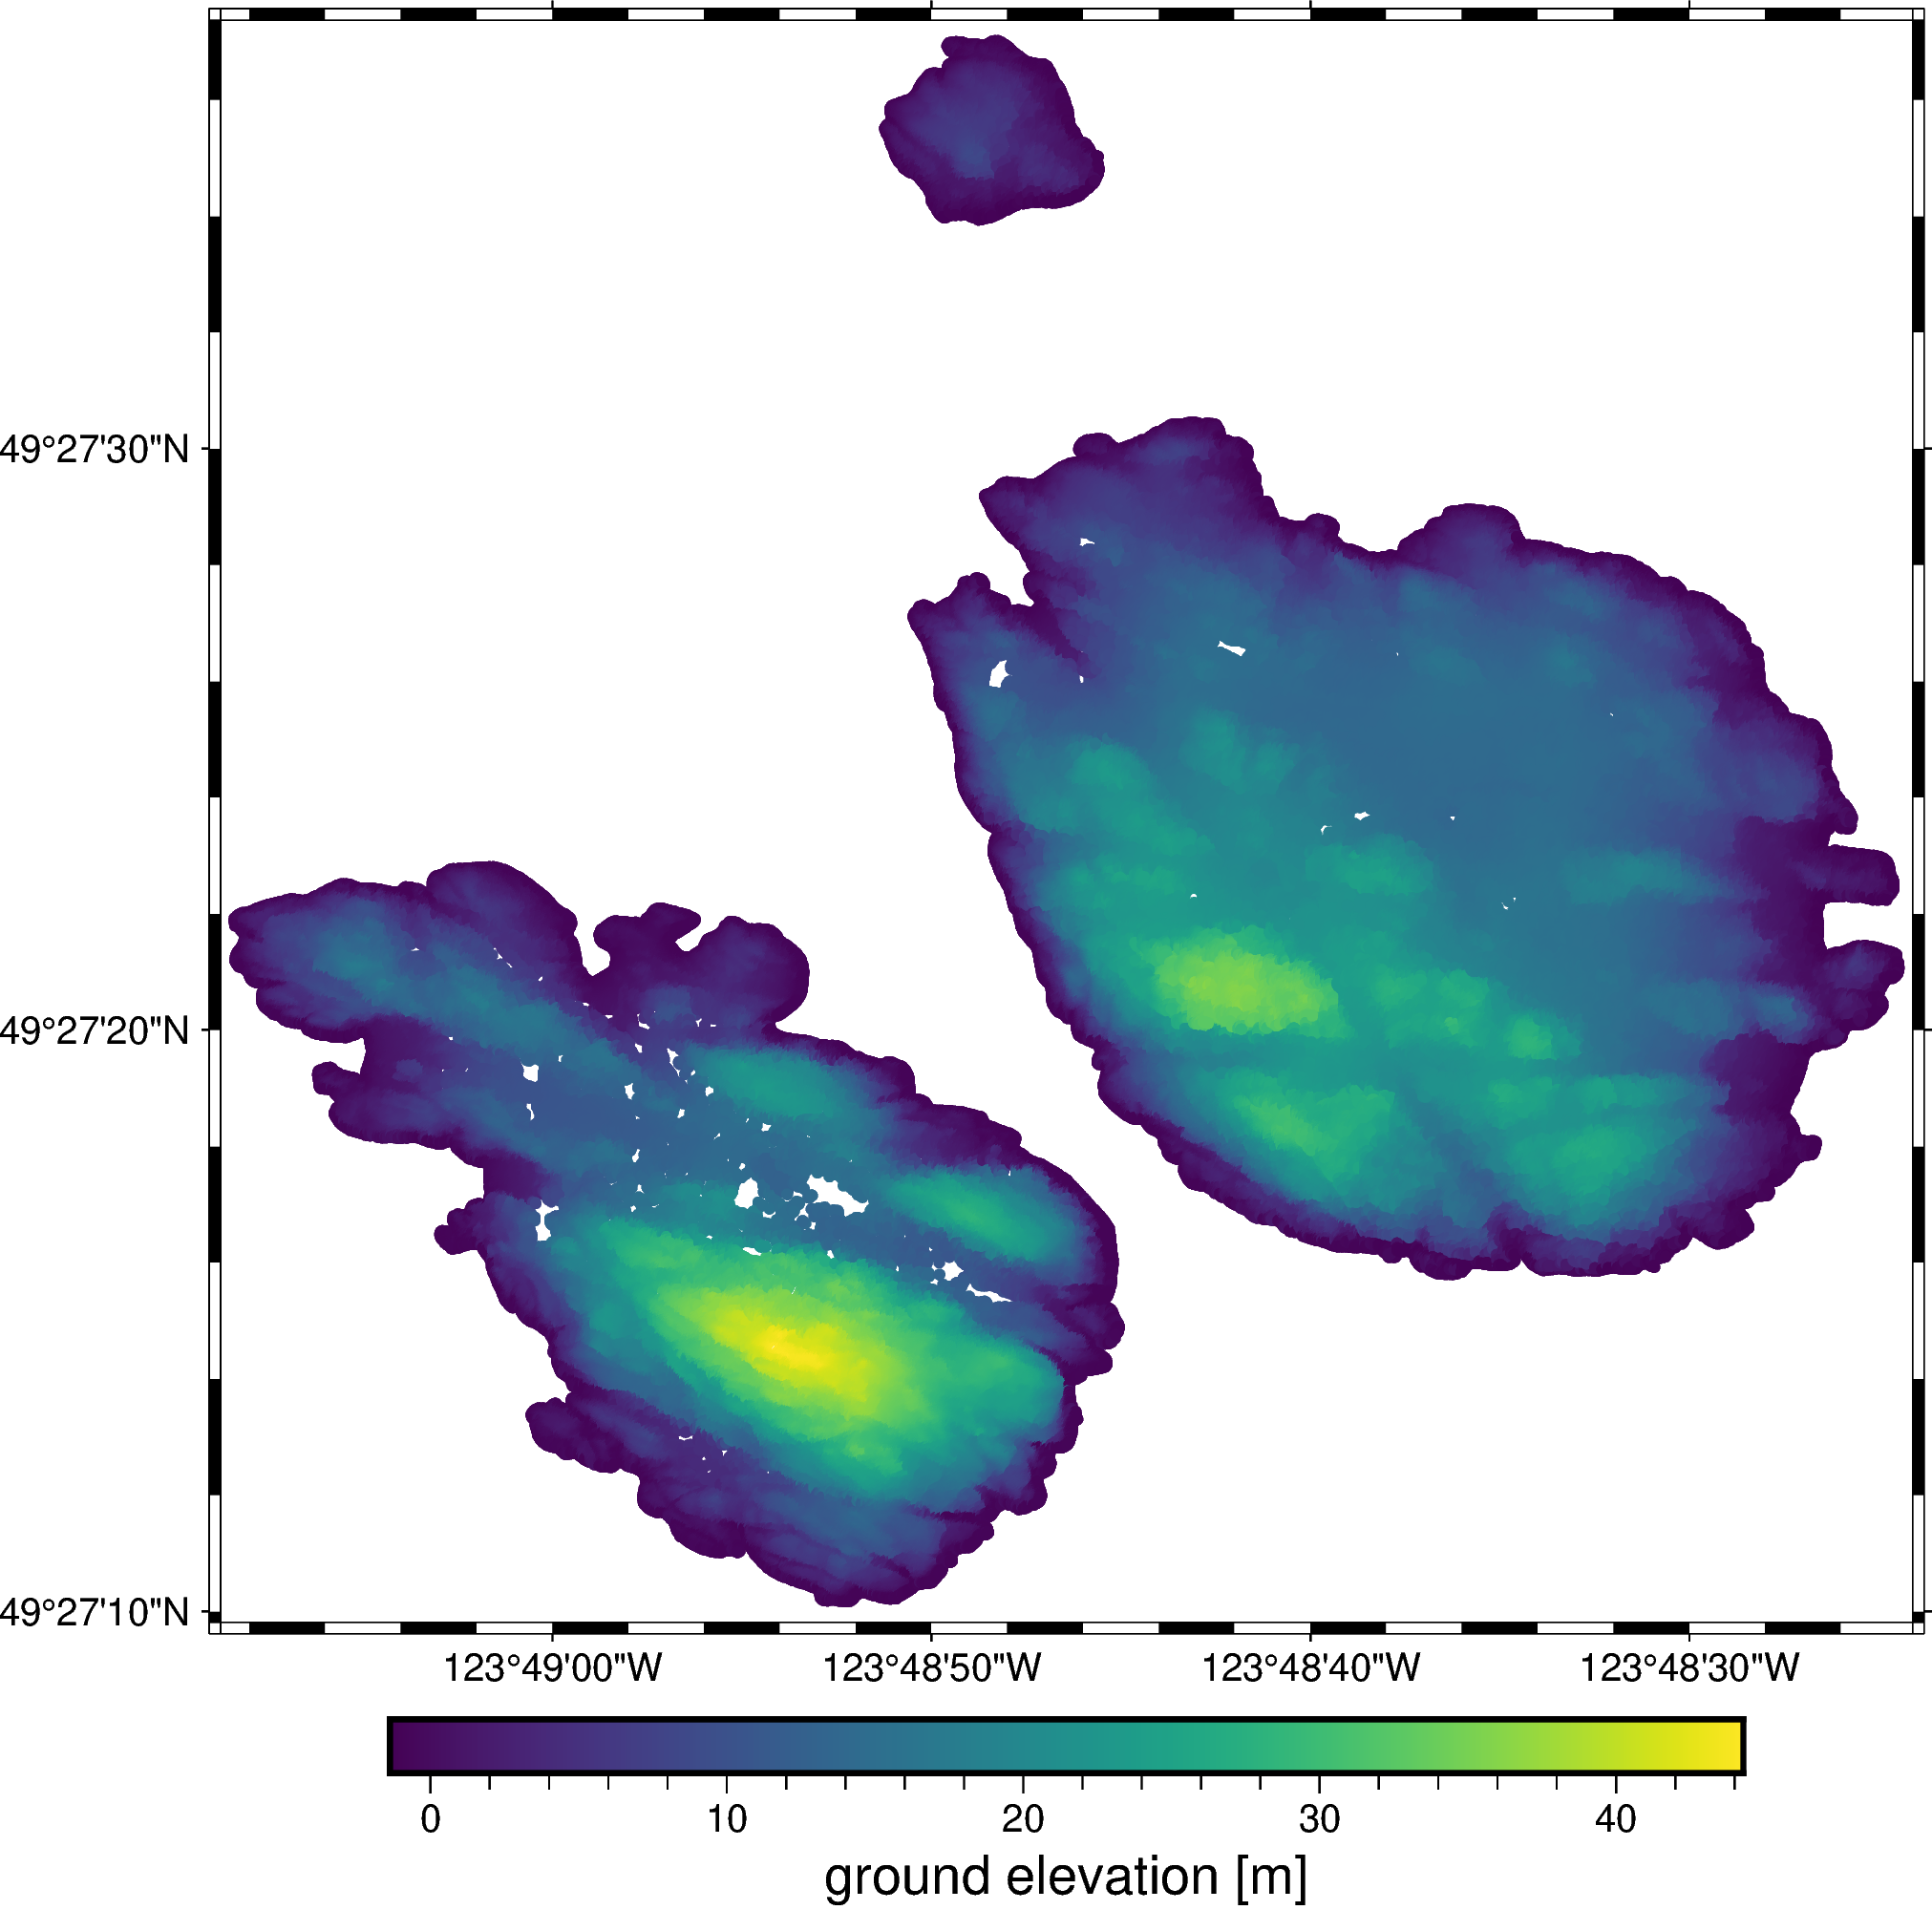

In [7]:
region = vd.pad_region(vd.get_region((data.longitude, data.latitude)), 0.0001)

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
pygmt.makecpt(cmap="viridis", series=[data.elevation_m.min(), data.elevation_m.max()])
fig.plot(
    x=data.longitude, 
    y=data.latitude, 
    color=data.elevation_m, 
    cmap=True, 
    style="c0.1c",
)
fig.colorbar(frame='af+l"ground elevation [m]"')
fig.savefig("preview.jpg", dpi=200)
fig.show()

## Export

Make a separate DataFrame to export to a compressed CSV. The conversion is needed to specify the number of significant digits to preserve in the output. Setting this along with the LZMA compression can help reduce the file size considerably. Not all fields in the original data need to be exported.

In [8]:
export = pd.DataFrame({
    "longitude": data.longitude.map(lambda x: "{:.7f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.7f}".format(x)),    
    "elevation_m": data.elevation_m.map(lambda x: "{:.2f}".format(x)),
})
export

,longitude,latitude,elevation_m
0,-123.8137526,49.4602634,-0.67
1,-123.8137253,49.4602745,-0.96
2,-123.8137636,49.4602538,-0.78
3,-123.8137440,49.4602617,-0.61
4,-123.8137369,49.4602645,-0.62
...,...,...,...
829728,-123.8074072,49.4550069,-1.24
829729,-123.8074104,49.4549953,-1.25
829730,-123.8074158,49.4549800,-1.19
829731,-123.8074280,49.4549665,-1.21


Save the data to a file and calculate the size and MD5/SHA256 hashes.

In [9]:
output = "british-columbia-lidar.csv.xz"
export.to_csv(output, index=False)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: british-columbia-lidar.csv.xz
size: 4.378076 Mb
md5:354c725a95036bd8340bc14e043ece5a
sha256:03c6f1b99374b8c00c424c788cb6956bc00ab477244bb69835d4171312714fe1


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [10]:
data_reloaded = pd.read_csv(output)
data_reloaded

,longitude,latitude,elevation_m
0,-123.813753,49.460263,-0.67
1,-123.813725,49.460274,-0.96
2,-123.813764,49.460254,-0.78
3,-123.813744,49.460262,-0.61
4,-123.813737,49.460265,-0.62
...,...,...,...
829728,-123.807407,49.455007,-1.24
829729,-123.807410,49.454995,-1.25
829730,-123.807416,49.454980,-1.19
829731,-123.807428,49.454966,-1.21


Make the figure again but don't save it to a file this time.

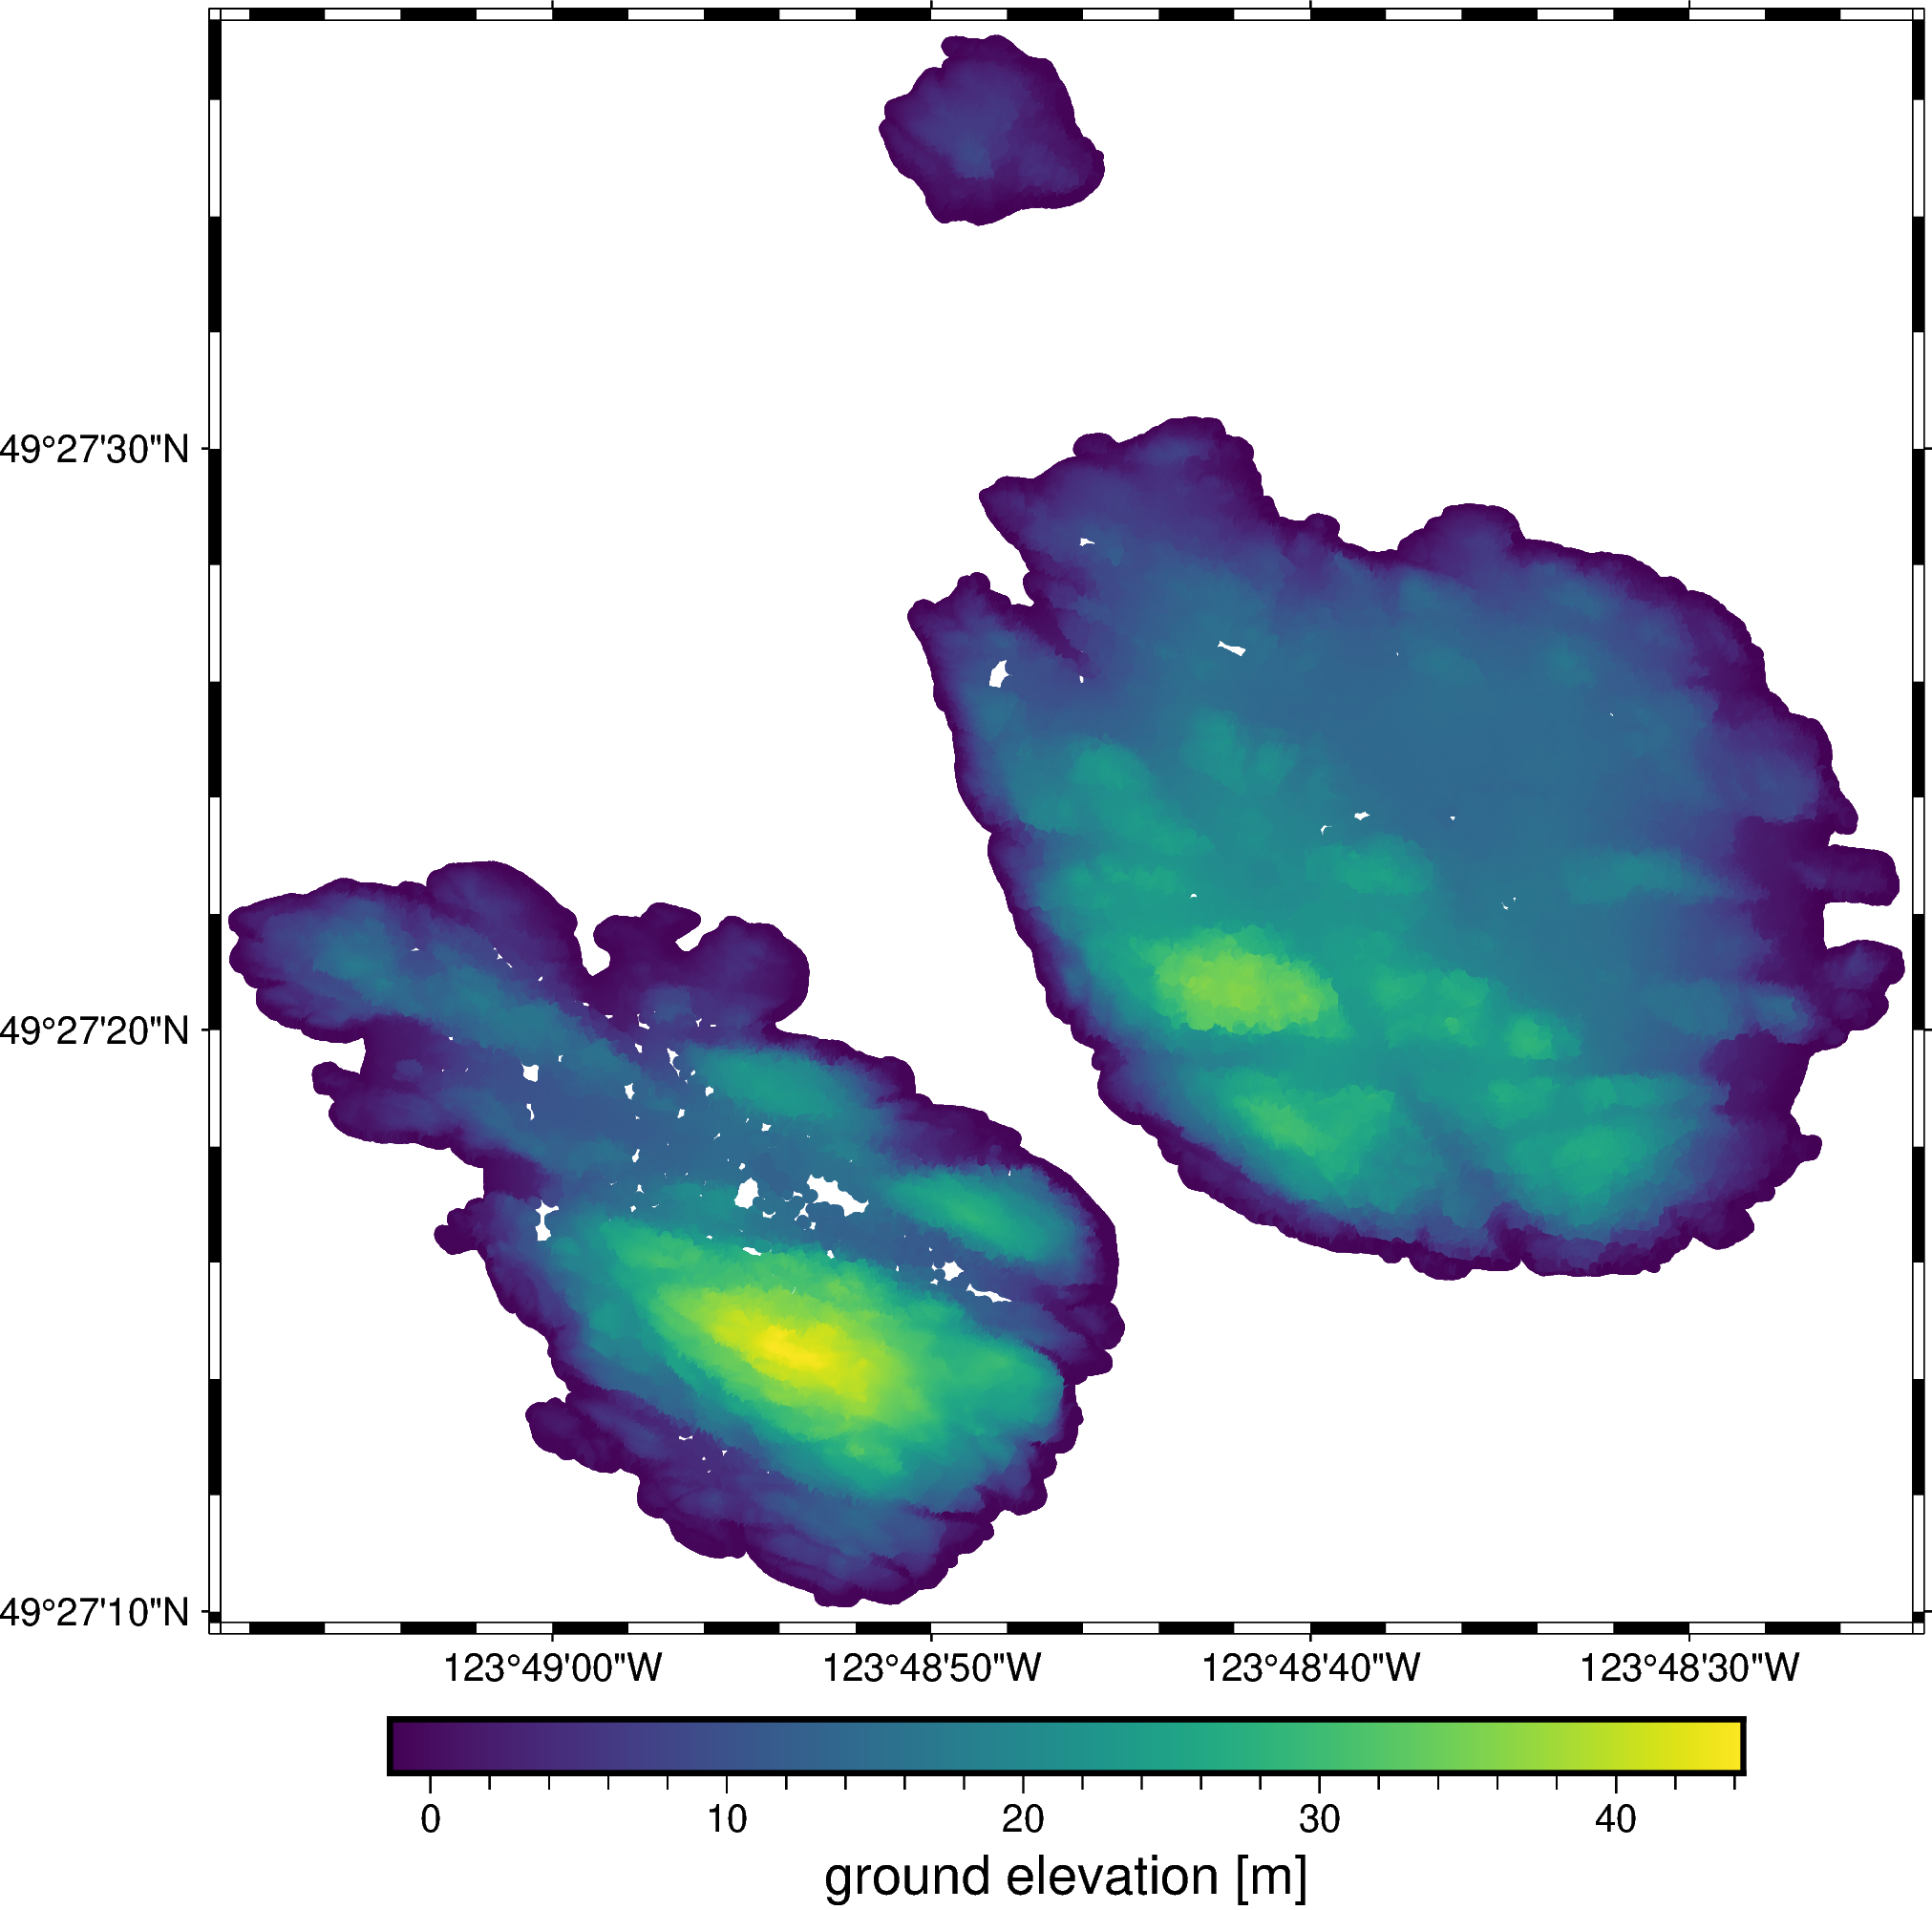

In [11]:
fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
pygmt.makecpt(cmap="viridis", series=[data_reloaded.elevation_m.min(), data_reloaded.elevation_m.max()])
fig.plot(
    x=data_reloaded.longitude, 
    y=data_reloaded.latitude, 
    color=data_reloaded.elevation_m, 
    cmap=True, 
    style="c0.1c",
)
fig.colorbar(frame='af+l"ground elevation [m]"')
fig.show()